In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import os
from PIL import Image

In [3]:
#pytorch
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

In [4]:
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Read in Metadata

In [5]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')

In [6]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Let's take a look at the 7 types of skin lesions

In [7]:
skin_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

For future processing, we need to convert our label to numbers

In [8]:
skin_df['cell_type_idx'] = pd.Categorical(skin_df['dx']).codes

In [9]:
skin_df['cell_type_idx'].value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: cell_type_idx, dtype: int64

## Read in Image

We have the data in the form of images, and we want to convert them into matrix format that works well with PyTorch

The first step is to match up the image filenames with their corresponding image id

In [10]:
data_dir = '../SkinLesionClassifier_data'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [11]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)

In [12]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,../SkinLesionClassifier_data/HAM10000_images_p...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,../SkinLesionClassifier_data/HAM10000_images_p...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,../SkinLesionClassifier_data/HAM10000_images_p...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,../SkinLesionClassifier_data/HAM10000_images_p...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,../SkinLesionClassifier_data/HAM10000_images_p...


## Data Preprocessing

### Fliter for unique lesion_id

Now we want to see if `lesion_id` is unique and keep only unduplicated images

In [13]:
# this will tell us how many images are associated with each lesion_id
df_undup = skin_df.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.shape

(5514, 9)

In [14]:
unique_id = pd.Series(df_undup['lesion_id'].unique())
skin_df_uniq = skin_df[skin_df['lesion_id'].isin(unique_id)]
skin_df_uniq.shape

(5514, 9)

In [15]:
# read in image and resize it to 100 x 100

In [16]:
#skin_df_uniq['image'] = skin_df_uniq['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))
skin_df_uniq['image'] = skin_df_uniq['path'].map(lambda x: np.asarray(Image.open(x)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
skin_df_uniq.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type_idx,path,image
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,2,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[22, 13, 16], [22, 11, 15], [22, 11, 15], [2..."
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,2,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[202, 160, 180], [198, 159, 178], [197, 160,..."
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,2,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,2,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[204, 209, 213], [205, 204, 209], [205, 203,..."
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,2,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[0, 0, 0], [0, 0, 0], [1, 1, 1], [6, 4, 7], ..."


### Train and test split

Next, we want to split the data into training and test sets

In [18]:
features = skin_df_uniq.drop('cell_type_idx', axis = 1)
target = skin_df_uniq['cell_type_idx']

In [19]:
x_train_o, x_test_o, Y_train, Y_test = train_test_split(features, target, test_size=0.20,random_state=118)

In [20]:
x_train_o = x_train_o.reset_index(drop = True)
x_test_o = x_test_o.reset_index(drop = True)
Y_train = Y_train.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)

### Imbalance class

We noticed from earlier that class 'nv' has dominated significantly more than the other classes. To ease future trouble cased by imbalanced classes, we will manually create more training samples for the other classes.

In [21]:
X_train = x_train_o
X_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image
0,HAM_0007508,ISIC_0025763,nv,histo,50.0,male,chest,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[124, 107, 113], [126, 109, 115], [124, 110,..."
1,HAM_0004054,ISIC_0031756,nv,histo,70.0,male,hand,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[167, 117, 106], [168, 120, 108], [170, 121,..."
2,HAM_0003661,ISIC_0026910,nv,follow_up,35.0,female,trunk,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[220, 137, 123], [224, 136, 126], [226, 138,..."
3,HAM_0006994,ISIC_0026987,nv,histo,30.0,male,foot,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[95, 48, 56], [97, 50, 58], [99, 50, 54], [9..."
4,HAM_0002050,ISIC_0032215,bkl,histo,40.0,male,scalp,../SkinLesionClassifier_data/HAM10000_images_p...,"[[[245, 214, 211], [251, 216, 214], [250, 214,..."


In [22]:
Y_train = pd.Series([int(x) for x in Y_train])

### Normalization

To reduce bias among the pictures, we standardlize the images base on their theoretical mean and standard deviation

In [23]:
def compute_img_mean_std(df):
    img_RGB = df['image'].values
    RGB_vals = []
    # for each image, get the mean for each RGB layer
    for i in range(len(img_RGB)):
        R = img_RGB[i][:,:,0]
        G = img_RGB[i][:,:,1]
        B = img_RGB[i][:,:,2]
        RGB_vals.append([np.mean(R)/255, np.mean(G)/255, np.mean(B)/255])
    # compute mean and std
    RGB_vals = np.array(RGB_vals)
    img_mean = np.mean(RGB_vals, axis = 0)
    img_std = np.std(RGB_vals, axis = 0)
    return img_mean, img_std
        

In [24]:
train_mean, train_std = compute_img_mean_std(X_train)
test_mean, test_std = compute_img_mean_std(x_test_o)

In [25]:
print(train_mean, train_std)

[0.80599225 0.52574493 0.54294557] [0.08590311 0.08508569 0.09202076]


In [26]:
print(test_mean, test_std)

[0.79933838 0.52175165 0.53925165] [0.08701616 0.08624265 0.09363755]


## Image transformation

In [27]:
# define an image loader
# this part is inspired 
# https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch#Step-1.-Data-analysis-and-preprocessing
class HAM10000(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.X['path'][index])
        #X = self.X
        #y = torch.tensor(int(self.df['cell_type_idx'][index]))
        y = torch.tensor(Y_train.values[index])

        if self.transform:
            X = self.transform(X)

        return X, y

In [28]:
input_size = 100
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(),
                                     transforms.Normalize(train_mean, train_std)])
# define the transformation of the val images.
test_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(test_mean, test_std)])

In [29]:
training_set = HAM10000(X_train,Y_train, transform=train_transform)
trainloader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

testing_set = HAM10000(x_test_o, Y_test,transform=test_transform)
testloader = DataLoader(testing_set, batch_size=32, shuffle=True, num_workers=4)

In [30]:
## try if trainloader is working
for i, data in enumerate(trainloader, 0):
    # Get the inputs.
    inputs, labels = data
    if i == 1:
        print(inputs.shape)
        print(labels)
        break

torch.Size([32, 3, 100, 100])
tensor([5, 0, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5])


## Network definition

In [31]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


First let's try a two-layer CNN

In [85]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ###### Fill the blank here ######
        # conv layer
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride = 1, padding = 1)
        
        # linear layer
        #self.fc1 = nn.Linear(20 * 8 * 8, 1280) 
        self.fc2 = nn.Linear(20000,32)
        self.fc3 = nn.Linear(32, 7)
       
        
    def forward(self, x):
        ###### Fill the blank here ######
        # two rounds of avg pooling
        # avg pooling over a (2, 2) window
        x = F.avg_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.avg_pool2d(F.relu(self.conv2(x)), 2)
        
        
        x = x.view(-1, self.num_flat_features(x))
        #x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
 
        return x

    def num_flat_features(self, x): # flatten matrix
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=20000, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=7, bias=True)
)

#### Optimizer and Loss Function

In [86]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

## Training Procedure

In [87]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 0.838
[epoch: 1, i:    99] avg mini-batch loss: 0.609
[epoch: 2, i:    99] avg mini-batch loss: 0.578
[epoch: 3, i:    99] avg mini-batch loss: 0.570
[epoch: 4, i:    99] avg mini-batch loss: 0.544
[epoch: 5, i:    99] avg mini-batch loss: 0.560
[epoch: 6, i:    99] avg mini-batch loss: 0.536
[epoch: 7, i:    99] avg mini-batch loss: 0.539
[epoch: 8, i:    99] avg mini-batch loss: 0.524
[epoch: 9, i:    99] avg mini-batch loss: 0.529
Finished Training.


#### Training Loss Curve

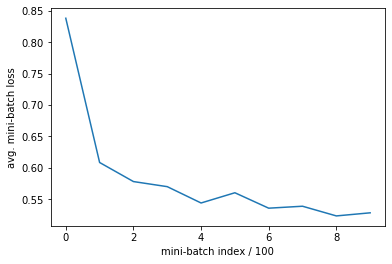

In [88]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [100]:
r_cnn_train = check_accuracy(device,net,7,trainloader)
r_cnn_test = check_accuracy(device,net,7,testloader)
print("train accuracy: " + str(r_cnn_train))
print("test accuracy: " + str(r_cnn_test))

train accuracy: 82.81568805259579
test accuracy: 74.1613780598368


In [101]:
each_cnn_train = accuracy_each_classes(device,net,7,trainloader,skin_df_uniq)

Accuracy of akiec :  4 %
Accuracy of   bcc : 59 %
Accuracy of   bkl : 34 %
Accuracy of    df :  0 %
Accuracy of   mel : 12 %
Accuracy of    nv : 96 %
Accuracy of  vasc : 11 %


In [102]:
each_cnn_test = accuracy_each_classes(device,net,7,testloader,skin_df_uniq)

Accuracy of akiec :  0 %
Accuracy of   bcc :  5 %
Accuracy of   bkl :  5 %
Accuracy of    df :  0 %
Accuracy of   mel :  7 %
Accuracy of    nv : 90 %
Accuracy of  vasc :  0 %


# Other Models

In [35]:
def convert_relu_to_sigmoid(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.Sigmoid())
        else:
            convert_relu_to_sigmoid(child)

In [36]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [43]:
def check_accuracy(device,model,classes,loader):
    # Get test accuracy.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [44]:
def accuracy_each_classes(device,model,classes,loader,skin_df_uniq):
    # Get test accuracy for each class.
    classes = list(skin_df_uniq['dx'].unique())
    classes = sorted(classes)
    class_correct = list(0. for i in range(7))
    class_total = list(0. for i in range(7))

    y_label = []
    y_predict = []


    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()

            y_label.extend(labels.cpu().numpy())
            y_predict.extend(np.squeeze(predicted.cpu().numpy().T))

            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    result = {}
    for i in range(7):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        result[classes[i]] = 100 * class_correct[i] / class_total[i]
    return result

In [45]:
opt_types = ["SGD","Adam"]
activations = ["relu","sigmoid"]

## Resnet

In [108]:
def resnet_models(model_name,num_classes,feature_extract, use_pretrained=True):
        # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "Resnet50":
        model_ft = torchvision.models.resnet50(pretrained=use_pretrained)
        
    elif model_name == "Resnet152":
        model_ft = torchvision.models.resnet152(pretrained=use_pretrained)

    else:
        print("Invalid model name, exiting...")
        exit()
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    return model_ft

In [109]:
resnet_types = ["Resnet50","Resnet152"]

Resnet50_relu_SGD


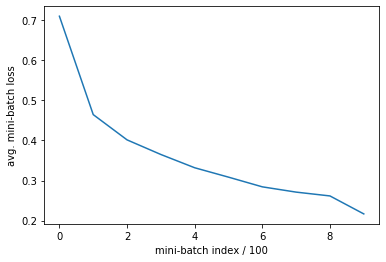

train accuracy: 82.52097030151893
test accuracy: 74.1613780598368
train accuracy for each class
Accuracy of akiec : 45 %
Accuracy of   bcc : 79 %
Accuracy of   bkl : 80 %
Accuracy of    df : 76 %
Accuracy of   mel : 57 %
Accuracy of    nv : 97 %
Accuracy of  vasc : 90 %
test accuracy for each class
Accuracy of akiec :  4 %
Accuracy of   bcc :  5 %
Accuracy of   bkl :  9 %
Accuracy of    df :  0 %
Accuracy of   mel :  4 %
Accuracy of    nv : 82 %
Accuracy of  vasc :  0 %


Resnet50_relu_Adam


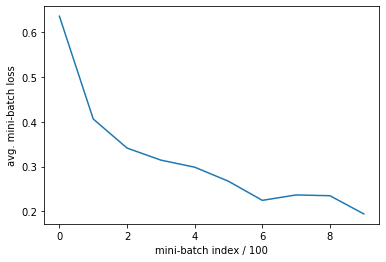

train accuracy: 83.17841759238269
test accuracy: 74.1613780598368
train accuracy for each class
Accuracy of akiec : 86 %
Accuracy of   bcc : 72 %
Accuracy of   bkl : 84 %
Accuracy of    df : 76 %
Accuracy of   mel : 56 %
Accuracy of    nv : 98 %
Accuracy of  vasc : 92 %
test accuracy for each class
Accuracy of akiec :  8 %
Accuracy of   bcc :  2 %
Accuracy of   bkl : 11 %
Accuracy of    df :  0 %
Accuracy of   mel :  4 %
Accuracy of    nv : 81 %
Accuracy of  vasc :  0 %


Resnet50_sigmoid_SGD


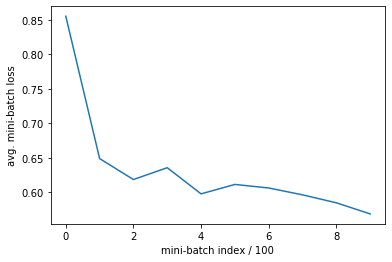

train accuracy: 82.52097030151893
test accuracy: 74.1613780598368
train accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel : 67 %
Accuracy of    nv : 93 %
Accuracy of  vasc :  0 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel : 24 %
Accuracy of    nv : 83 %
Accuracy of  vasc :  0 %


Resnet50_sigmoid_Adam


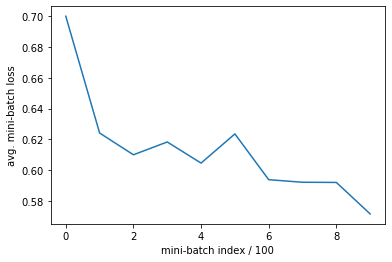

train accuracy: 82.92904103377919
test accuracy: 74.1613780598368
train accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl : 60 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 95 %
Accuracy of  vasc :  0 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl : 14 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 83 %
Accuracy of  vasc :  0 %


Resnet152_relu_SGD


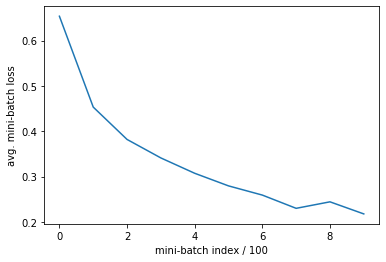

train accuracy: 83.24642938109272
test accuracy: 74.1613780598368
train accuracy for each class
Accuracy of akiec : 60 %
Accuracy of   bcc : 77 %
Accuracy of   bkl : 74 %
Accuracy of    df : 66 %
Accuracy of   mel : 44 %
Accuracy of    nv : 98 %
Accuracy of  vasc : 90 %
test accuracy for each class
Accuracy of akiec :  4 %
Accuracy of   bcc :  2 %
Accuracy of   bkl :  9 %
Accuracy of    df :  0 %
Accuracy of   mel :  2 %
Accuracy of    nv : 90 %
Accuracy of  vasc :  0 %


Resnet152_relu_Adam


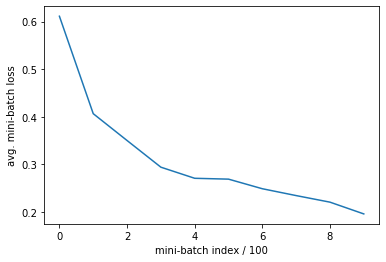

train accuracy: 82.88369984130583
test accuracy: 74.1613780598368
train accuracy for each class
Accuracy of akiec : 51 %
Accuracy of   bcc : 93 %
Accuracy of   bkl : 74 %
Accuracy of    df : 83 %
Accuracy of   mel : 60 %
Accuracy of    nv : 98 %
Accuracy of  vasc : 96 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  5 %
Accuracy of   bkl :  6 %
Accuracy of    df :  0 %
Accuracy of   mel :  7 %
Accuracy of    nv : 82 %
Accuracy of  vasc :  0 %


Resnet152_sigmoid_SGD


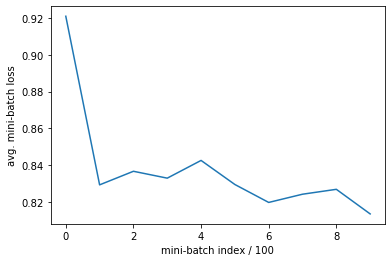

train accuracy: 82.7930174563591
test accuracy: 74.1613780598368
train accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %


Resnet152_sigmoid_Adam


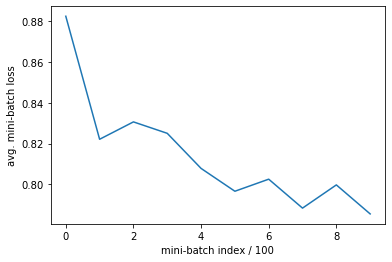

train accuracy: 82.92904103377919
test accuracy: 74.1613780598368
train accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %




In [112]:
num_classes = 7
resnet_train = {}
resnet_test = {}
resnet_train_class = []
resnet_test_class = []
titles = []
for k in resnet_types:
    for n in activations:
        for m in opt_types:
                # Initialize the model for this run
                model_c = resnet_models(k, num_classes,False)
                
                #choose activation function
                if n=="sigmoid":
                    convert_relu_to_sigmoid(model_c)
                
                # Define the device:
                device = torch.device('cuda:0')
                # Put the model on the device:
                model = model_c.to(device)
                avg_losses = []   # Avg. losses.
                
                
                # We use cross-entropy as loss function.
                loss_func = nn.CrossEntropyLoss()
                #choose optimizer
                if m == "SGD":
                    # We use stochastic gradient descent (SGD) as optimizer.
                    opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
                else:
                    # We use Adam as optimizer.
                    opt= optim.Adam(model.parameters(), lr=0.0001)

                epochs = 10       # Total epochs.
                print_freq = 100  # Print frequency.

                for epoch in range(epochs):  # Loop over the dataset multiple times.
                    running_loss = 0.0       # Initialize running loss.
                    for i, data in enumerate(trainloader, 0):
                        # Get the inputs.
                        inputs, labels = data

                        # Move the inputs to the specified device.
                        inputs, labels = inputs.to(device), labels.to(device)

                        # Zero the parameter gradients.
                        opt.zero_grad()

                        # Forward step.
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)

                        # Backward step.
                        loss.backward()

                        # Optimization step (update the parameters).
                        opt.step()

                        # Print statistics.
                        running_loss += loss.item()
                        if i % print_freq == print_freq - 1: # Print every several mini-batches.
                            avg_loss = running_loss / print_freq
                            avg_losses.append(avg_loss)
                            running_loss = 0.0
                #print type of model
                title = k+"_"+n+"_"+m
                titles.append(title)
                print(title)
                
                #train error curve
                plt.plot(avg_losses)
                plt.xlabel('mini-batch index / {}'.format(print_freq))
                plt.ylabel('avg. mini-batch loss')
                plt.show()
                
                # Get  accuracy.
                train_accuracy = check_accuracy(device,model,num_classes,trainloader)
                test_accuracy = check_accuracy(device,model,num_classes,testloader)
                resnet_train[title] = train_accuracy
                resnet_test[title] = test_accuracy
                print("train accuracy: " + str(train_accuracy))
                print("test accuracy: " + str(test_accuracy))
                print("train accuracy for each class")
                resnet_train_class.append(accuracy_each_classes(device,model,num_classes,trainloader,skin_df_uniq))
                print("test accuracy for each class")
                resnet_test_class.append(accuracy_each_classes(device,model,num_classes,testloader,skin_df_uniq))
                print("\n")

In [115]:
resnet_train

{'Resnet50_relu_SGD': 82.52097030151893,
 'Resnet50_relu_Adam': 83.17841759238269,
 'Resnet50_sigmoid_SGD': 82.52097030151893,
 'Resnet50_sigmoid_Adam': 82.92904103377919,
 'Resnet152_relu_SGD': 83.24642938109272,
 'Resnet152_relu_Adam': 82.88369984130583,
 'Resnet152_sigmoid_SGD': 82.7930174563591,
 'Resnet152_sigmoid_Adam': 82.92904103377919}

In [116]:
resnet_test

{'Resnet50_relu_SGD': 74.1613780598368,
 'Resnet50_relu_Adam': 74.1613780598368,
 'Resnet50_sigmoid_SGD': 74.1613780598368,
 'Resnet50_sigmoid_Adam': 74.1613780598368,
 'Resnet152_relu_SGD': 74.1613780598368,
 'Resnet152_relu_Adam': 74.1613780598368,
 'Resnet152_sigmoid_SGD': 74.1613780598368,
 'Resnet152_sigmoid_Adam': 74.1613780598368}

## Vgg

In [46]:
def vgg_models(model_name,num_classes,feature_extract, use_pretrained=True):
        # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "vgg11":
        model_ft = torchvision.models.vgg11(pretrained=use_pretrained)
        
    elif model_name == "vgg11_bn":
        model_ft = torchvision.models.vgg11_bn(pretrained=use_pretrained)
    
    elif model_name == "vgg19":
        model_ft = torchvision.models.vgg19(pretrained=use_pretrained)

    else:
        print("Invalid model name, exiting...")
        exit()
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    return model_ft

In [47]:
vgg_types = ['vgg11',"vgg11_bn","vgg19"]

vgg11_relu_SGD


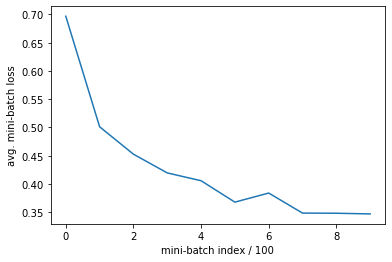

train accuracy: 89.39016096123328
test accuracy: 67.45240253853127
train accuracy for each class
Accuracy of akiec : 48 %
Accuracy of   bcc : 64 %
Accuracy of   bkl : 61 %
Accuracy of    df : 33 %
Accuracy of   mel : 53 %
Accuracy of    nv : 96 %
Accuracy of  vasc : 82 %
test accuracy for each class
Accuracy of akiec : 16 %
Accuracy of   bcc :  2 %
Accuracy of   bkl :  7 %
Accuracy of    df :  0 %
Accuracy of   mel : 12 %
Accuracy of    nv : 81 %
Accuracy of  vasc :  0 %


vgg11_relu_Adam


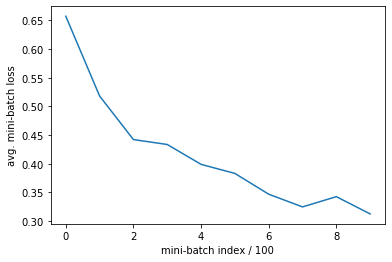

train accuracy: 89.7302199047835
test accuracy: 67.81504986400725
train accuracy for each class
Accuracy of akiec : 55 %
Accuracy of   bcc : 81 %
Accuracy of   bkl : 59 %
Accuracy of    df : 30 %
Accuracy of   mel : 42 %
Accuracy of    nv : 97 %
Accuracy of  vasc : 90 %
test accuracy for each class
Accuracy of akiec :  8 %
Accuracy of   bcc :  2 %
Accuracy of   bkl :  3 %
Accuracy of    df :  0 %
Accuracy of   mel :  7 %
Accuracy of    nv : 82 %
Accuracy of  vasc :  0 %


vgg11_sigmoid_SGD


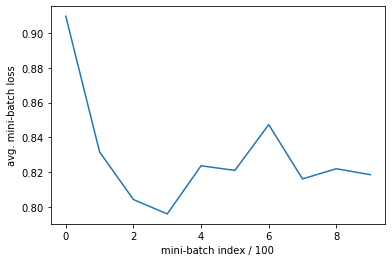

train accuracy: 80.00453411924734
test accuracy: 80.96101541251133
train accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %


vgg11_sigmoid_Adam


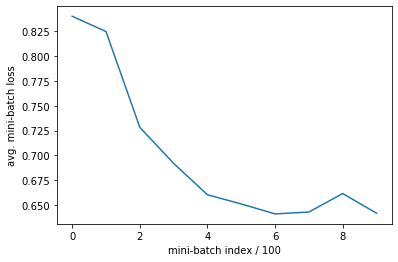

train accuracy: 80.00453411924734
test accuracy: 80.96101541251133
train accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %




Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /tmp/xdg-cache/torch/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:03<00:00, 134MB/s]  


vgg11_bn_relu_SGD


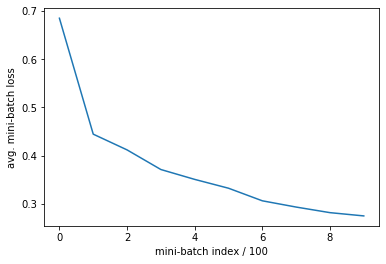

train accuracy: 91.20380866016777
test accuracy: 68.08703535811424
train accuracy for each class
Accuracy of akiec : 49 %
Accuracy of   bcc : 71 %
Accuracy of   bkl : 77 %
Accuracy of    df : 73 %
Accuracy of   mel : 55 %
Accuracy of    nv : 97 %
Accuracy of  vasc : 86 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  2 %
Accuracy of   bkl :  9 %
Accuracy of    df :  0 %
Accuracy of   mel :  9 %
Accuracy of    nv : 81 %
Accuracy of  vasc :  0 %


vgg11_bn_relu_Adam


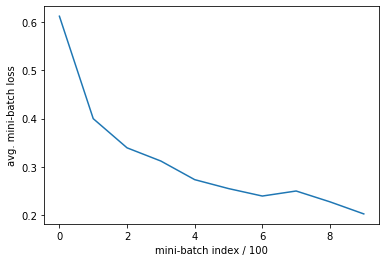

train accuracy: 93.58422126501927
test accuracy: 67.1804170444243
train accuracy for each class
Accuracy of akiec : 69 %
Accuracy of   bcc : 60 %
Accuracy of   bkl : 84 %
Accuracy of    df : 93 %
Accuracy of   mel : 58 %
Accuracy of    nv : 98 %
Accuracy of  vasc : 96 %
test accuracy for each class
Accuracy of akiec :  4 %
Accuracy of   bcc :  0 %
Accuracy of   bkl : 10 %
Accuracy of    df :  0 %
Accuracy of   mel :  7 %
Accuracy of    nv : 80 %
Accuracy of  vasc :  0 %


vgg11_bn_sigmoid_SGD


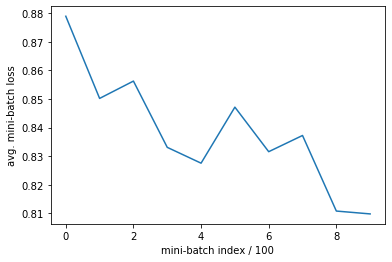

train accuracy: 80.00453411924734
test accuracy: 80.96101541251133
train accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %


vgg11_bn_sigmoid_Adam


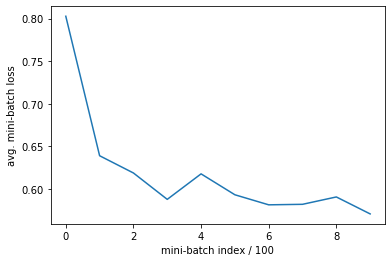

train accuracy: 78.87100430741329
test accuracy: 67.1804170444243
train accuracy for each class
Accuracy of akiec : 20 %
Accuracy of   bcc : 11 %
Accuracy of   bkl : 29 %
Accuracy of    df :  0 %
Accuracy of   mel :  3 %
Accuracy of    nv : 93 %
Accuracy of  vasc :  0 %
test accuracy for each class
Accuracy of akiec :  4 %
Accuracy of   bcc :  2 %
Accuracy of   bkl :  8 %
Accuracy of    df :  0 %
Accuracy of   mel :  2 %
Accuracy of    nv : 82 %
Accuracy of  vasc :  0 %




Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/xdg-cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 122MB/s]  


vgg19_relu_SGD


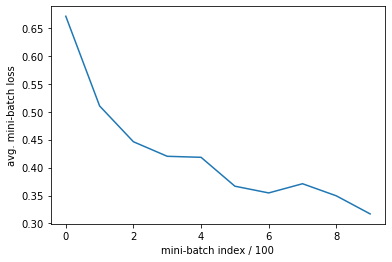

train accuracy: 87.30446610745862
test accuracy: 69.62828649138713
train accuracy for each class
Accuracy of akiec : 35 %
Accuracy of   bcc : 62 %
Accuracy of   bkl : 28 %
Accuracy of    df : 60 %
Accuracy of   mel : 66 %
Accuracy of    nv : 97 %
Accuracy of  vasc : 82 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  2 %
Accuracy of   bkl :  4 %
Accuracy of    df :  0 %
Accuracy of   mel : 14 %
Accuracy of    nv : 83 %
Accuracy of  vasc :  0 %


vgg19_relu_Adam


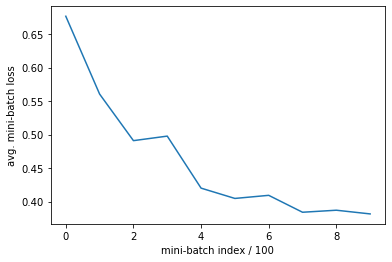

train accuracy: 87.66719564724552
test accuracy: 67.72438803263826
train accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc : 44 %
Accuracy of   bkl : 60 %
Accuracy of    df :  0 %
Accuracy of   mel : 53 %
Accuracy of    nv : 97 %
Accuracy of  vasc : 86 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  2 %
Accuracy of   bkl : 10 %
Accuracy of    df :  0 %
Accuracy of   mel : 14 %
Accuracy of    nv : 81 %
Accuracy of  vasc :  0 %


vgg19_sigmoid_SGD


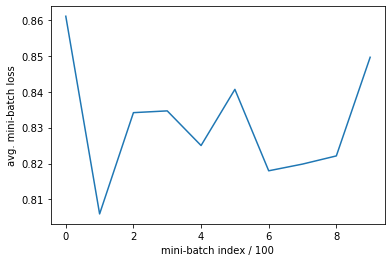

train accuracy: 80.00453411924734
test accuracy: 80.96101541251133
train accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %


vgg19_sigmoid_Adam


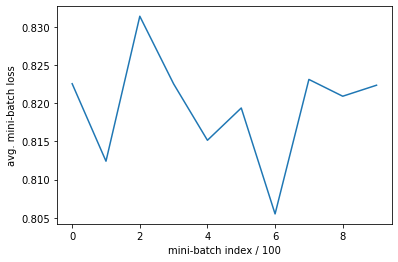

train accuracy: 80.00453411924734
test accuracy: 80.96101541251133
train accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %
test accuracy for each class
Accuracy of akiec :  0 %
Accuracy of   bcc :  0 %
Accuracy of   bkl :  0 %
Accuracy of    df :  0 %
Accuracy of   mel :  0 %
Accuracy of    nv : 100 %
Accuracy of  vasc :  0 %




In [48]:
num_classes = 7
vgg_train = {}
vgg_test = {}
vgg_train_class = []
vgg_test_class = []
vgg_titles = []
for k in vgg_types:
    for n in activations:
        for m in opt_types:
                # Initialize the model for this run
                model_c = vgg_models(k, num_classes,False)
                
                #choose activation function
                if n=="sigmoid":
                    convert_relu_to_sigmoid(model_c)
                
                # Define the device:
                device = torch.device('cuda:0')
                # Put the model on the device:
                model = model_c.to(device)
                avg_losses = []   # Avg. losses.
                
                
                # We use cross-entropy as loss function.
                loss_func = nn.CrossEntropyLoss()
                #choose optimizer
                if m == "SGD":
                    # We use stochastic gradient descent (SGD) as optimizer.
                    opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
                else:
                    # We use Adam as optimizer.
                    opt= optim.Adam(model.parameters(), lr=0.0001)

                epochs = 10       # Total epochs.
                print_freq = 100  # Print frequency.

                for epoch in range(epochs):  # Loop over the dataset multiple times.
                    running_loss = 0.0       # Initialize running loss.
                    for i, data in enumerate(trainloader, 0):
                        # Get the inputs.
                        inputs, labels = data

                        # Move the inputs to the specified device.
                        inputs, labels = inputs.to(device), labels.to(device)

                        # Zero the parameter gradients.
                        opt.zero_grad()

                        # Forward step.
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)

                        # Backward step.
                        loss.backward()

                        # Optimization step (update the parameters).
                        opt.step()

                        # Print statistics.
                        running_loss += loss.item()
                        if i % print_freq == print_freq - 1: # Print every several mini-batches.
                            avg_loss = running_loss / print_freq
                            avg_losses.append(avg_loss)
                            running_loss = 0.0
                #print type of model
                title = k+"_"+n+"_"+m
                vgg_titles.append(title)
                print(title)
                
                #train error curve
                plt.plot(avg_losses)
                plt.xlabel('mini-batch index / {}'.format(print_freq))
                plt.ylabel('avg. mini-batch loss')
                plt.show()
                
                # Get  accuracy.
                train_accuracy = check_accuracy(device,model,num_classes,trainloader)
                test_accuracy = check_accuracy(device,model,num_classes,testloader)
                vgg_train[title] = train_accuracy
                vgg_test[title] = test_accuracy
                print("train accuracy: " + str(train_accuracy))
                print("test accuracy: " + str(test_accuracy))
                print("train accuracy for each class")
                vgg_train_class.append(accuracy_each_classes(device,model,num_classes,trainloader,skin_df_uniq))
                print("test accuracy for each class")
                vgg_test_class.append(accuracy_each_classes(device,model,num_classes,testloader,skin_df_uniq))
                print("\n")

In [49]:
vgg_train

{'vgg11_relu_SGD': 89.39016096123328,
 'vgg11_relu_Adam': 89.7302199047835,
 'vgg11_sigmoid_SGD': 80.00453411924734,
 'vgg11_sigmoid_Adam': 80.00453411924734,
 'vgg11_bn_relu_SGD': 91.20380866016777,
 'vgg11_bn_relu_Adam': 93.58422126501927,
 'vgg11_bn_sigmoid_SGD': 80.00453411924734,
 'vgg11_bn_sigmoid_Adam': 78.87100430741329,
 'vgg19_relu_SGD': 87.30446610745862,
 'vgg19_relu_Adam': 87.66719564724552,
 'vgg19_sigmoid_SGD': 80.00453411924734,
 'vgg19_sigmoid_Adam': 80.00453411924734}

In [50]:
vgg_test

{'vgg11_relu_SGD': 67.45240253853127,
 'vgg11_relu_Adam': 67.81504986400725,
 'vgg11_sigmoid_SGD': 80.96101541251133,
 'vgg11_sigmoid_Adam': 80.96101541251133,
 'vgg11_bn_relu_SGD': 68.08703535811424,
 'vgg11_bn_relu_Adam': 67.1804170444243,
 'vgg11_bn_sigmoid_SGD': 80.96101541251133,
 'vgg11_bn_sigmoid_Adam': 67.1804170444243,
 'vgg19_relu_SGD': 69.62828649138713,
 'vgg19_relu_Adam': 67.72438803263826,
 'vgg19_sigmoid_SGD': 80.96101541251133,
 'vgg19_sigmoid_Adam': 80.96101541251133}

# END

# ResNet

In [101]:
model_resnet = torchvision.models.resnet152(pretrained=True)

In [39]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False           

In [40]:
def convert_relu_to_sigmoid(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.Sigmoid())
        else:
            convert_relu_to_sigmoid(child)

In [105]:
convert_relu_to_sigmoid(model_resnet)
set_parameter_requires_grad(model_resnet)

In [80]:
num_classes = 7
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, num_classes)
#input_size = 224

In [81]:
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_resnet.to(device)

In [82]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# We use Adam as optimizer.
#opt= optim.Adam([var1, var2], lr=0.0001)

In [83]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 0.326
[epoch: 0, i:   199] avg mini-batch loss: 0.350
[epoch: 0, i:   299] avg mini-batch loss: 0.335
[epoch: 0, i:   399] avg mini-batch loss: 0.311
[epoch: 0, i:   499] avg mini-batch loss: 0.349
[epoch: 0, i:   599] avg mini-batch loss: 0.332
[epoch: 1, i:    99] avg mini-batch loss: 0.326
[epoch: 1, i:   199] avg mini-batch loss: 0.310
[epoch: 1, i:   299] avg mini-batch loss: 0.328
[epoch: 1, i:   399] avg mini-batch loss: 0.324
[epoch: 1, i:   499] avg mini-batch loss: 0.300
[epoch: 1, i:   599] avg mini-batch loss: 0.321
[epoch: 2, i:    99] avg mini-batch loss: 0.321
[epoch: 2, i:   199] avg mini-batch loss: 0.283
[epoch: 2, i:   299] avg mini-batch loss: 0.293
[epoch: 2, i:   399] avg mini-batch loss: 0.305
[epoch: 2, i:   499] avg mini-batch loss: 0.289
[epoch: 2, i:   599] avg mini-batch loss: 0.292
[epoch: 3, i:    99] avg mini-batch loss: 0.304
[epoch: 3, i:   199] avg mini-batch loss: 0.329
[epoch: 3, i:   299] avg mini-batch loss

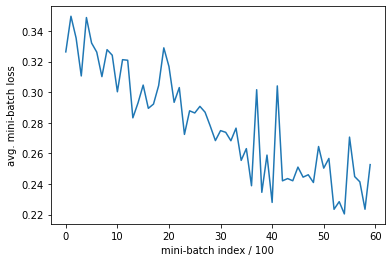

In [84]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

# VGG

In [48]:
model_ft = models.vgg19(pretrained=True)
set_parameter_requires_grad(model_ft)
#convert_relu_to_sigmoid(model_ft)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,7)
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

In [49]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

In [50]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.094
[epoch: 0, i:   199] avg mini-batch loss: 1.994
[epoch: 0, i:   299] avg mini-batch loss: 2.067
[epoch: 0, i:   399] avg mini-batch loss: 1.988
[epoch: 0, i:   499] avg mini-batch loss: 2.038
[epoch: 0, i:   599] avg mini-batch loss: 2.017
[epoch: 1, i:    99] avg mini-batch loss: 2.000
[epoch: 1, i:   199] avg mini-batch loss: 2.010
[epoch: 1, i:   299] avg mini-batch loss: 2.022
[epoch: 1, i:   399] avg mini-batch loss: 2.071
[epoch: 1, i:   499] avg mini-batch loss: 2.041
[epoch: 1, i:   599] avg mini-batch loss: 1.947
[epoch: 2, i:    99] avg mini-batch loss: 2.052
[epoch: 2, i:   199] avg mini-batch loss: 2.028
[epoch: 2, i:   299] avg mini-batch loss: 2.019
[epoch: 2, i:   399] avg mini-batch loss: 2.000
[epoch: 2, i:   499] avg mini-batch loss: 1.951
[epoch: 2, i:   599] avg mini-batch loss: 2.007
[epoch: 3, i:    99] avg mini-batch loss: 2.086
[epoch: 3, i:   199] avg mini-batch loss: 2.056
[epoch: 3, i:   299] avg mini-batch loss

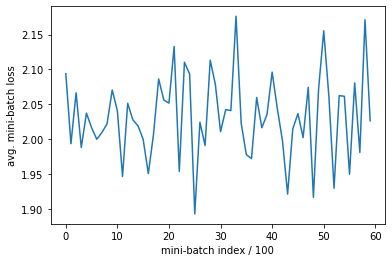

In [51]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

#### Evaluate on Test Dataset

In [45]:
# Check several images.
## (SKIPPED for now)
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

NameError: name 'imshow' is not defined

In [44]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 40 %


In [48]:
# Get test accuracy for each class.
classes = list(skin_df_uniq['dx'].unique())
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

y_label = []
y_predict = []


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(predicted.cpu().numpy().T))

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(7):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   bkl : 12 %
Accuracy of    nv :  2 %
Accuracy of    df : 13 %
Accuracy of   mel :  0 %
Accuracy of  vasc : 17 %
Accuracy of   bcc : 47 %
Accuracy of akiec :  0 %


In [48]:
pd.Series(y_predict).value_counts()

5    614
2    210
4     98
1     57
0     50
3     44
6     30
dtype: int64

In [49]:
print(classification_report(y_label, y_predict, target_names=classes))

              precision    recall  f1-score   support

         bkl       0.02      0.04      0.03        24
          nv       0.02      0.03      0.02        36
          df       0.08      0.17      0.10        95
         mel       0.00      0.00      0.00         4
        vasc       0.05      0.12      0.07        41
         bcc       0.81      0.56      0.66       893
       akiec       0.00      0.00      0.00        10

    accuracy                           0.47      1103
   macro avg       0.14      0.13      0.13      1103
weighted avg       0.67      0.47      0.55      1103

